# Installing Libraries and Pre-requisites

In [1]:
pip install yfinance

#Data Collection using API

In [6]:
import pandas as pd
import yfinance as yf
from datetime import date, timedelta

# Define the time period
end_date = date.today().strftime("%Y-%m-%d")
start_date = (date.today() - timedelta(days=365)).strftime("%Y-%m-%d")

# List of stock tickers to download
tickers = ['RELIANCE.NS', 'TCS.NS', 'INFY.NS', 'HDFCBANK.NS']

# Download stock data
data = yf.download(tickers, start=start_date, end=end_date, progress=False)

# Reset index to bring 'Date' into columns
data = data.reset_index()

# Flatten the multi-level column index
data.columns = ['Date'] + [f'{col[0]}_{col[1]}' for col in data.columns[1:]]

# Melt the DataFrame to long format
data_melted = data.melt(id_vars='Date', var_name='Combined', value_name='Value')

# Split 'Combined' into 'Attribute' and 'Ticker'
data_melted[['Attribute', 'Ticker']] = data_melted['Combined'].str.split('_', expand=True)

# Drop the combined column
data_melted = data_melted.drop(columns='Combined')

# Pivot to have attributes as columns
data_pivoted = data_melted.pivot_table(index=['Date', 'Ticker'], columns='Attribute', values='Value', aggfunc='first')

# Reset index to make it a flat DataFrame
stock_data = data_pivoted.reset_index()

print(stock_data.head())


Attribute       Date       Ticker        Close         High          Low  \
0         2024-06-12  HDFCBANK.NS  1574.150024  1588.300049  1566.400024   
1         2024-06-12      INFY.NS  1448.104614  1471.066461  1445.715855   
2         2024-06-12  RELIANCE.NS  1458.375244  1471.007420  1450.252909   
3         2024-06-12       TCS.NS  3770.885010  3831.754247  3766.751664   
4         2024-06-13  HDFCBANK.NS  1580.750000  1585.699951  1574.000000   

Attribute         Open      Volume  
0          1575.000000  19640218.0  
1          1469.360171   9564320.0  
2          1452.569996  10081742.0  
3          3812.957051   2177001.0  
4          1581.750000  12060096.0  


#Performance Over Time

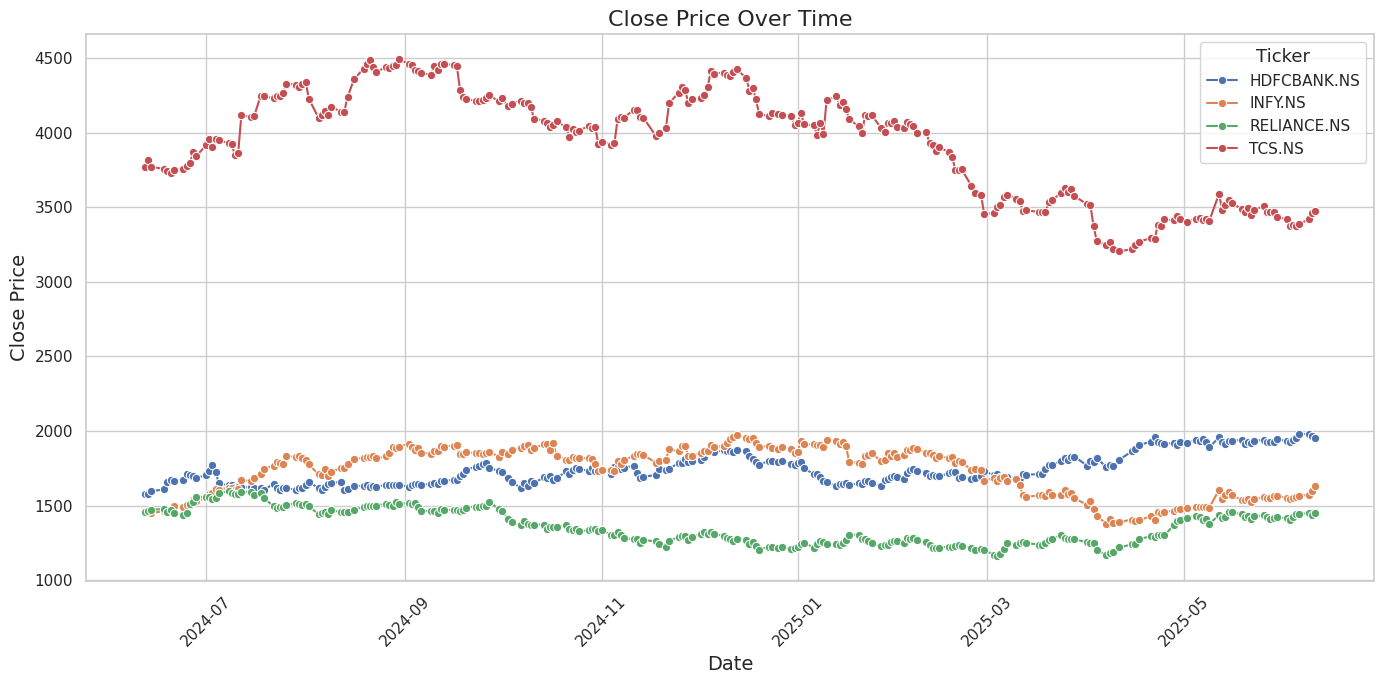

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure Date is in datetime format
stock_data['Date'] = pd.to_datetime(stock_data['Date'])

# Plotting
plt.figure(figsize=(14, 7))
sns.set(style='whitegrid')

# Use 'Close' if 'Adj Close' is missing
if 'Adj Close' in stock_data.columns:
    price_col = 'Adj Close'
else:
    price_col = 'Close'

# Lineplot
sns.lineplot(data=stock_data, x='Date', y=price_col, hue='Ticker', marker='o')

plt.title(f'{price_col} Price Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel(f'{price_col} Price', fontsize=14)
plt.legend(title='Ticker', title_fontsize='13', fontsize='11')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# 50 and 200 Moving Average

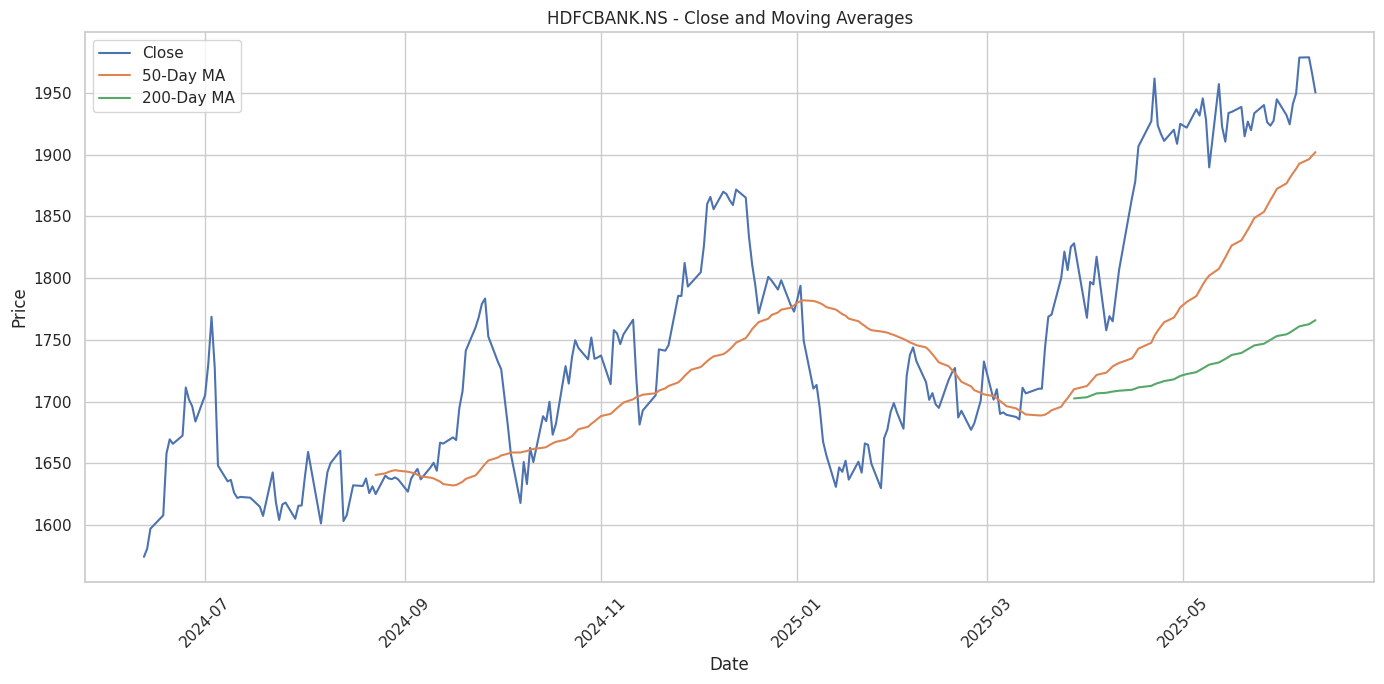

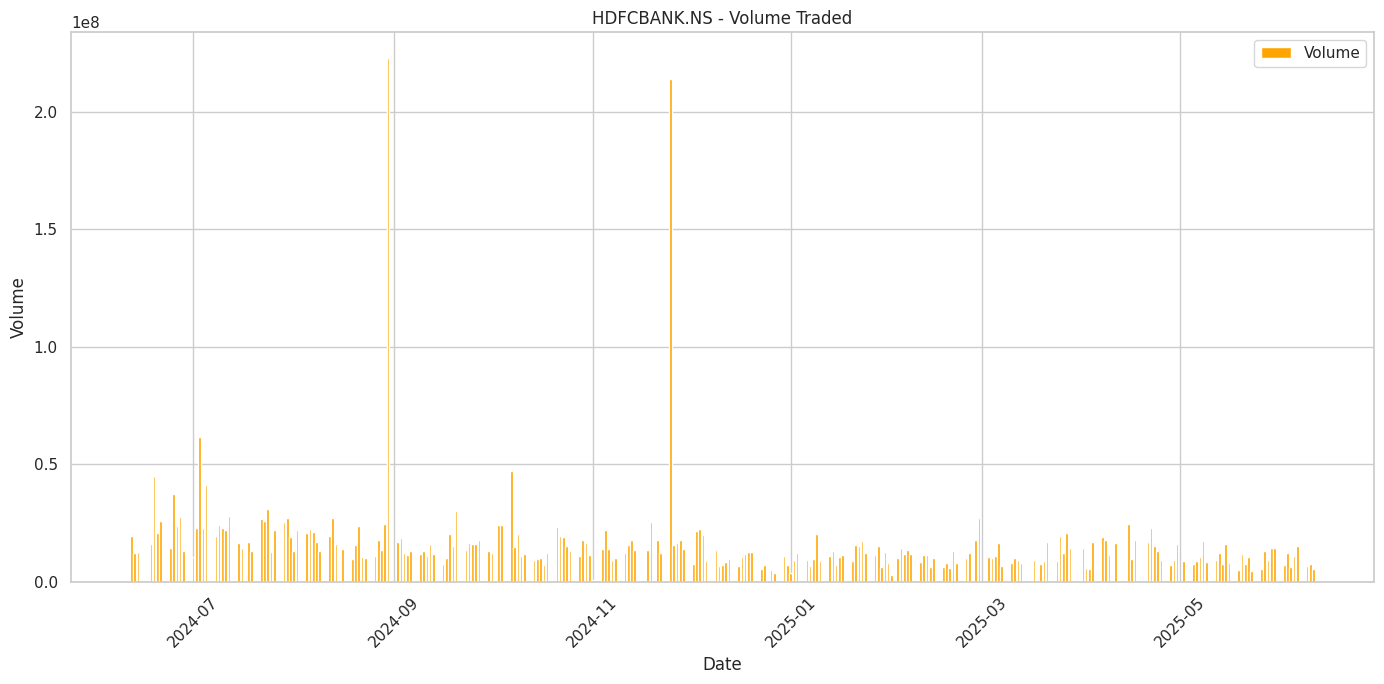

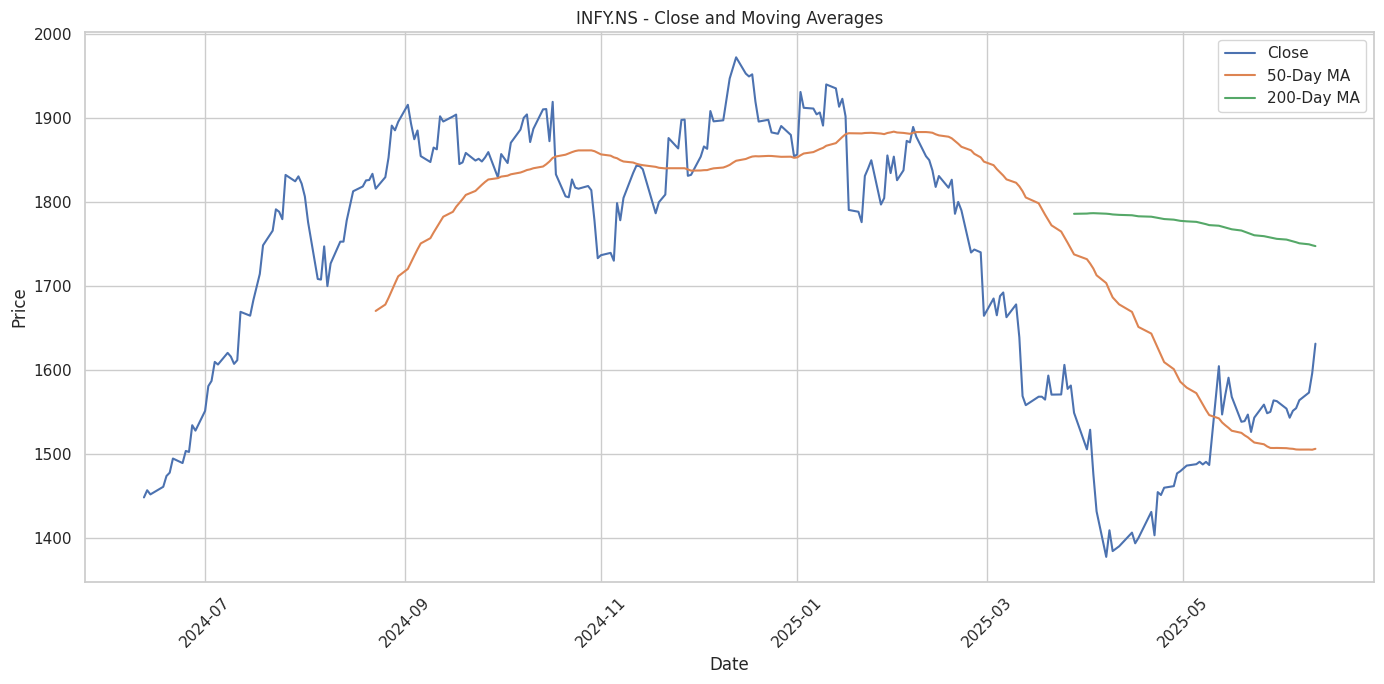

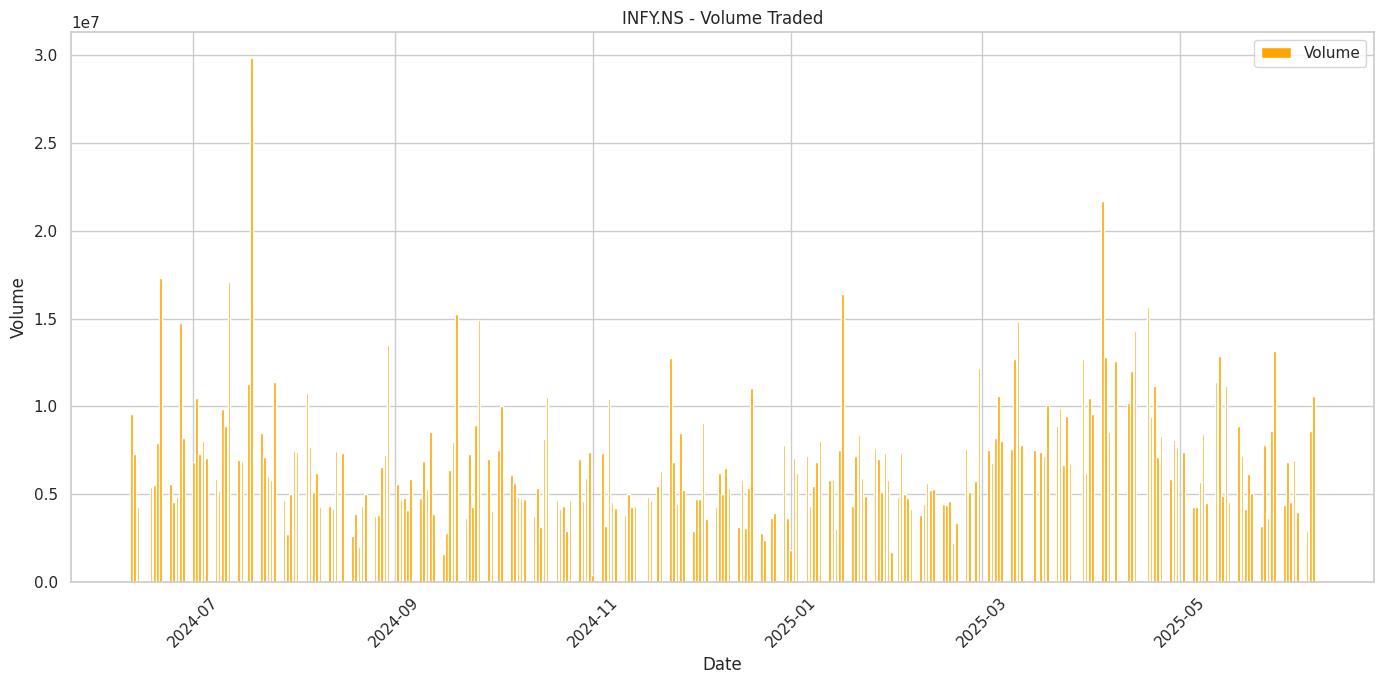

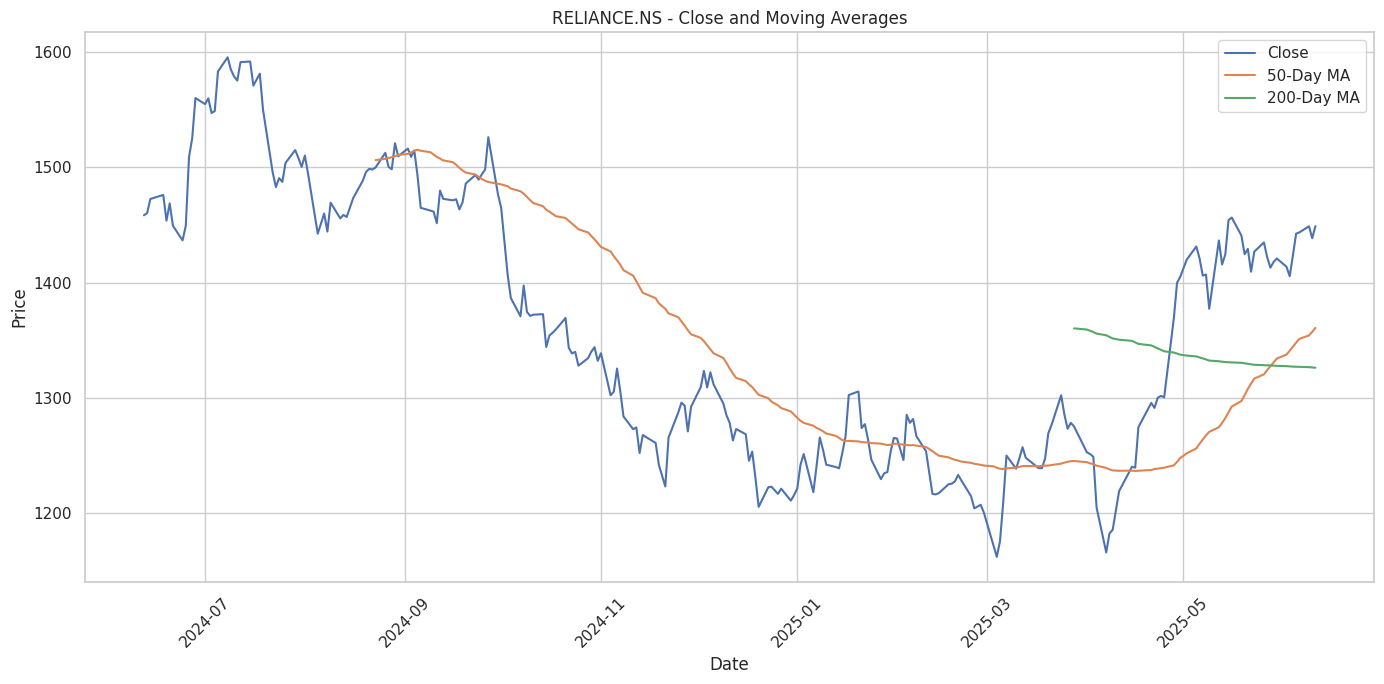

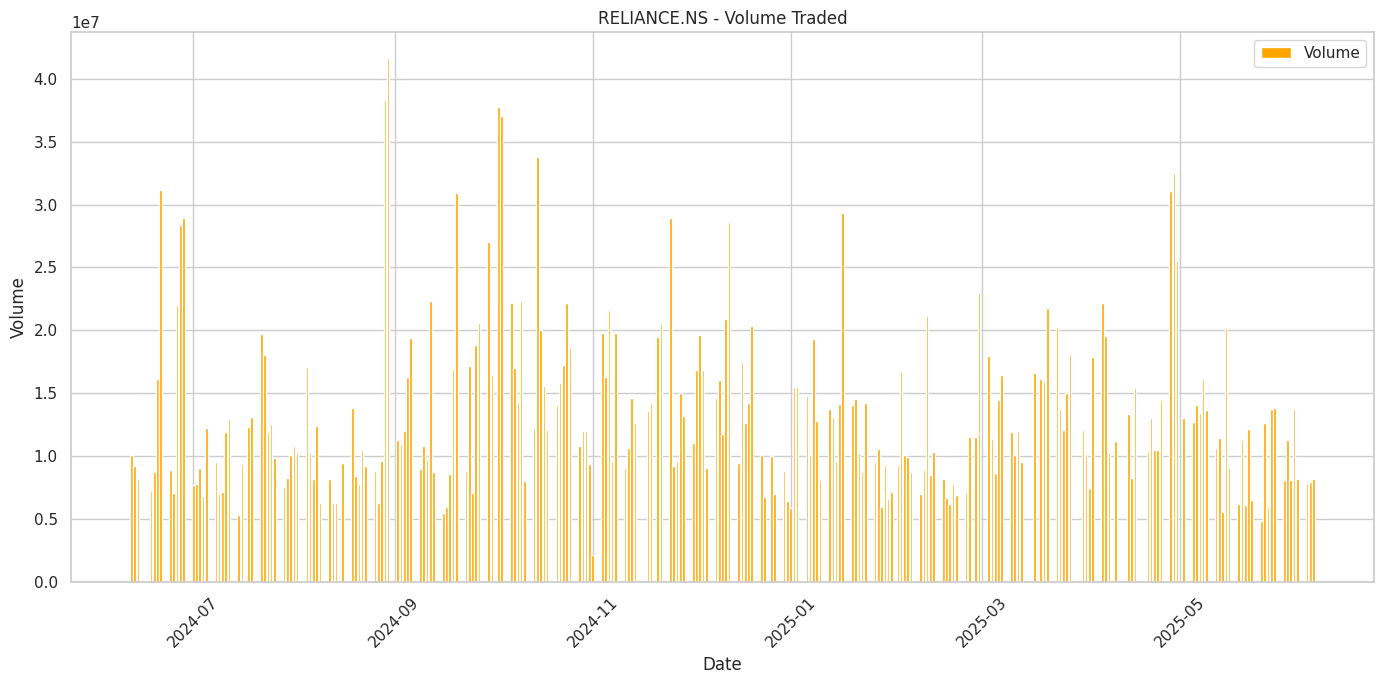

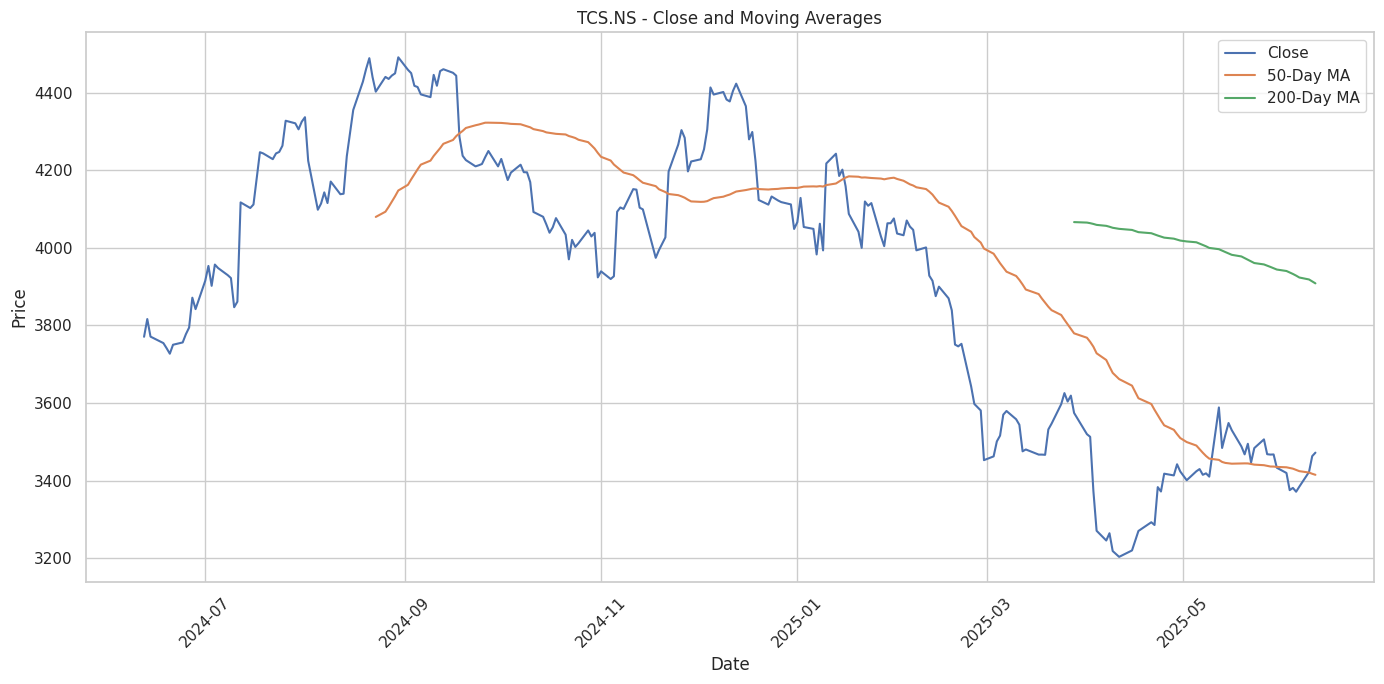

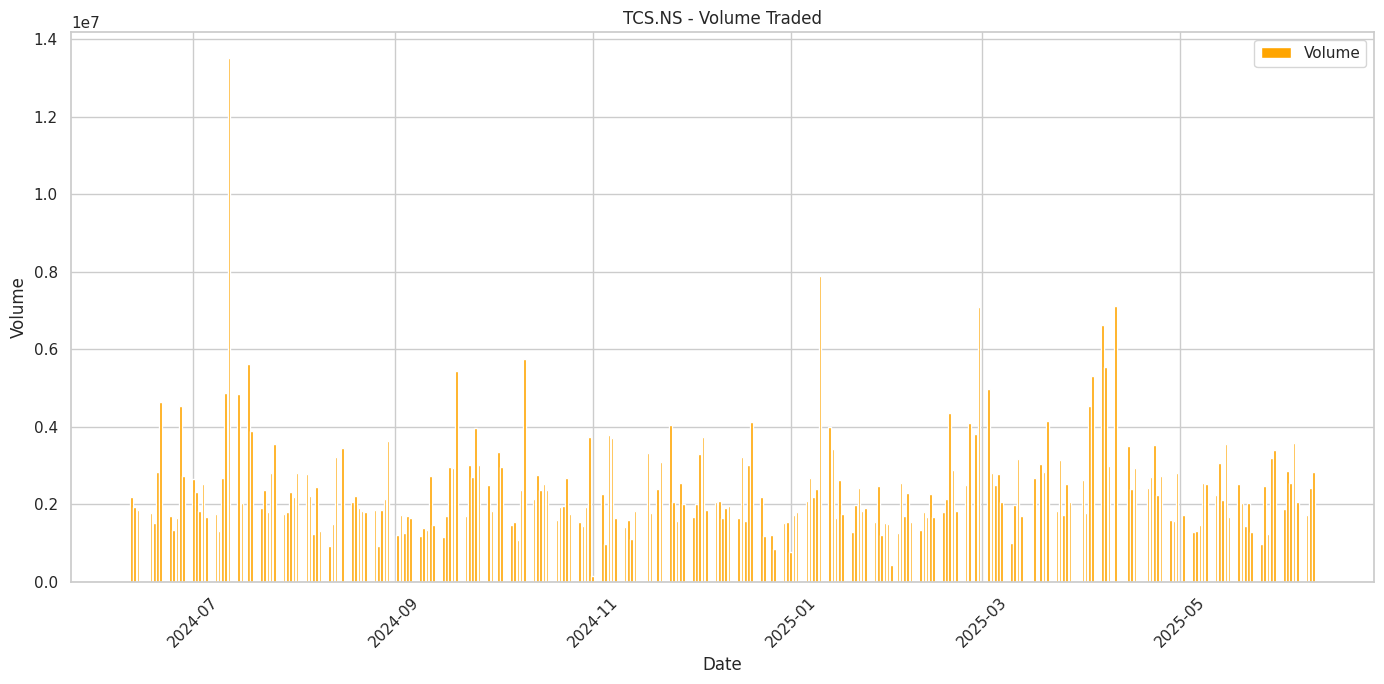

In [11]:
short_window = 50
long_window = 200

# Use 'Close' if 'Adj Close' not available
price_col = 'Adj Close' if 'Adj Close' in stock_data.columns else 'Close'

# Make sure 'Date' is the index
if 'Date' in stock_data.columns:
    stock_data.set_index('Date', inplace=True)

unique_tickers = stock_data['Ticker'].unique()

for ticker in unique_tickers:
    ticker_data = stock_data[stock_data['Ticker'] == ticker].copy()

    ticker_data[f'{short_window}_MA'] = ticker_data[price_col].rolling(window=short_window).mean()
    ticker_data[f'{long_window}_MA'] = ticker_data[price_col].rolling(window=long_window).mean()

    # Plot price with moving averages
    plt.figure(figsize=(14, 7))
    plt.plot(ticker_data.index, ticker_data[price_col], label=price_col)
    plt.plot(ticker_data.index, ticker_data[f'{short_window}_MA'], label=f'{short_window}-Day MA')
    plt.plot(ticker_data.index, ticker_data[f'{long_window}_MA'], label=f'{long_window}-Day MA')
    plt.title(f'{ticker} - {price_col} and Moving Averages')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Plot volume (if available)
    if 'Volume' in ticker_data.columns:
        plt.figure(figsize=(14, 7))
        plt.bar(ticker_data.index, ticker_data['Volume'], label='Volume', color='orange')
        plt.title(f'{ticker} - Volume Traded')
        plt.xlabel('Date')
        plt.ylabel('Volume')
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    else:
        print(f"Volume data not available for {ticker}")


# Daily Return Distribution

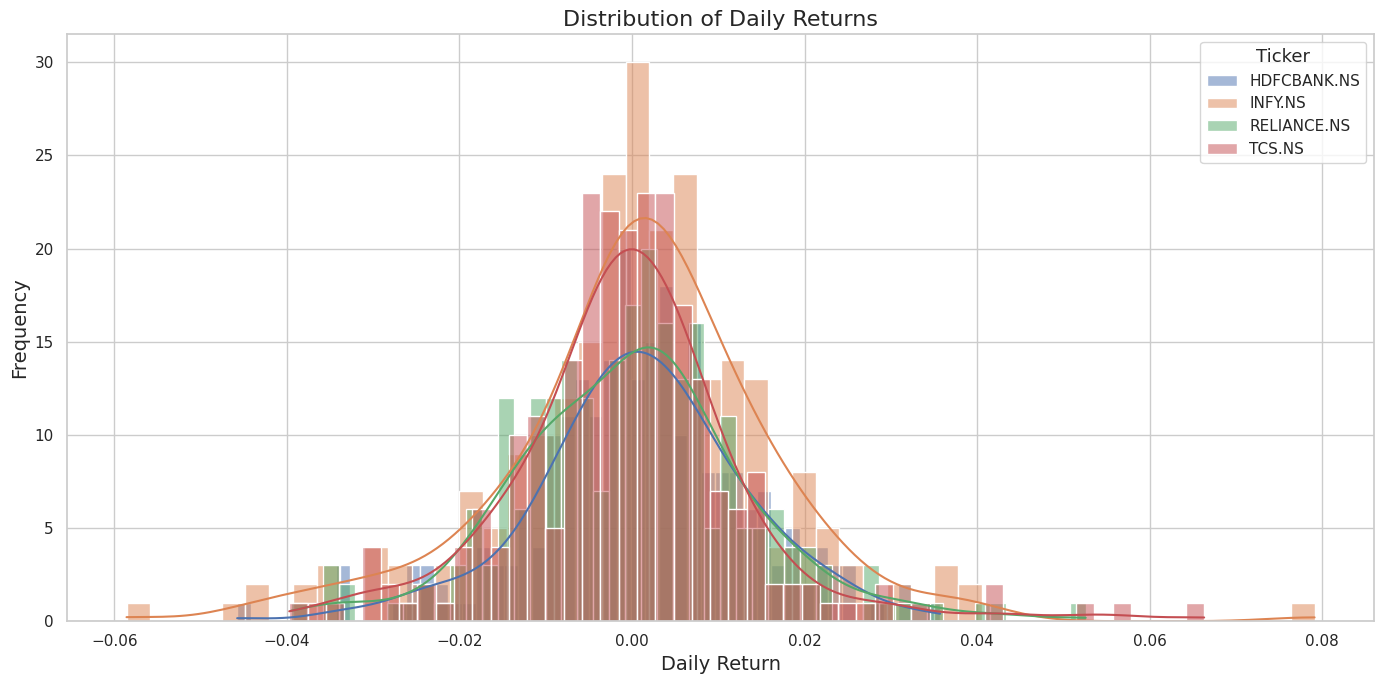

In [12]:
# Step 1: Use 'Close' if 'Adj Close' not present
price_col = 'Adj Close' if 'Adj Close' in stock_data.columns else 'Close'

# Step 2: Compute daily returns
stock_data['Daily Return'] = stock_data.groupby('Ticker')[price_col].pct_change()

# Step 3: Plot distribution
plt.figure(figsize=(14, 7))
sns.set(style='whitegrid')

for ticker in stock_data['Ticker'].unique():
    ticker_data = stock_data[stock_data['Ticker'] == ticker]
    sns.histplot(ticker_data['Daily Return'].dropna(), bins=50, kde=True, label=ticker, alpha=0.5)

plt.title('Distribution of Daily Returns', fontsize=16)
plt.xlabel('Daily Return', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend(title='Ticker', title_fontsize='13', fontsize='11')
plt.grid(True)
plt.tight_layout()
plt.show()


#Correlation

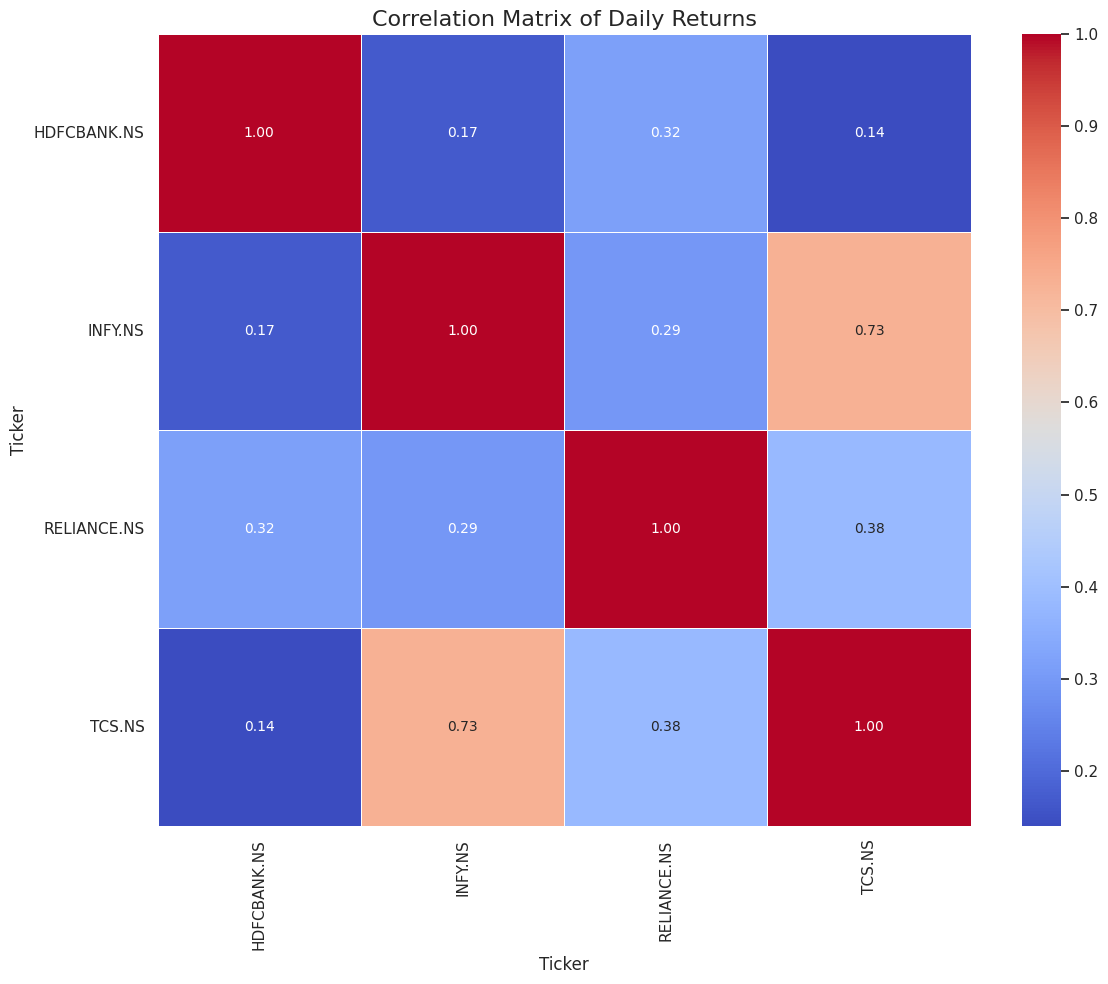

In [13]:
# Step 1: Ensure 'Date' is a column
if stock_data.index.name == 'Date':
    stock_data = stock_data.reset_index()

# Step 2: Confirm 'Daily Return' exists
price_col = 'Adj Close' if 'Adj Close' in stock_data.columns else 'Close'
if 'Daily Return' not in stock_data.columns:
    stock_data['Daily Return'] = stock_data.groupby('Ticker')[price_col].pct_change()

# Step 3: Pivot to create daily return matrix
daily_returns = stock_data.pivot_table(index='Date', columns='Ticker', values='Daily Return')

# Step 4: Compute correlation matrix
correlation_matrix = daily_returns.corr()

# Step 5: Plot heatmap
plt.figure(figsize=(12, 10))
sns.set(style='whitegrid')

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5, fmt='.2f', annot_kws={"size": 10})
plt.title('Correlation Matrix of Daily Returns', fontsize=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


#Portfolio Optimization

Now, using Modern Portfolio Theory, we can construct an efficient portfolio by balancing risk and return. We will:

Calculate the expected returns and volatility for each stock.
Generate a series of random portfolios to identify the efficient frontier.
Optimize the portfolio to maximize the Sharpe ratio, which is a measure of risk-adjusted return.
Let’s calculate the expected returns and volatility for each stock:

In [14]:
import numpy as np

expected_returns = daily_returns.mean() * 252  # annualize the returns
volatility = daily_returns.std() * np.sqrt(252)  # annualize the volatility

stock_stats = pd.DataFrame({
    'Expected Return': expected_returns,
    'Volatility': volatility
})

stock_stats

,Expected Return,Volatility
Ticker,,
HDFCBANK.NS,0.237803,0.195426
INFY.NS,0.153612,0.254150
RELIANCE.NS,0.016765,0.217083
TCS.NS,-0.060587,0.218816


Now we will:

Generate a large number of random portfolio weights. Calculate the expected return and volatility for each portfolio and plot these portfolios to visualize the efficient frontier.

Generating the random portfolios and plot the efficient frontier:

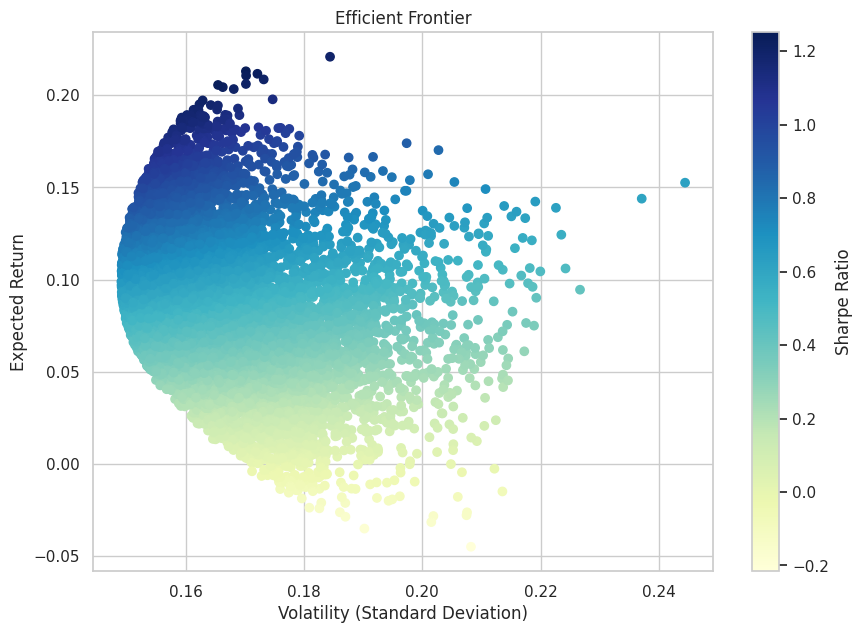

In [15]:
# function to calculate portfolio performance
def portfolio_performance(weights, returns, cov_matrix):
    portfolio_return = np.dot(weights, returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return portfolio_return, portfolio_volatility

# number of portfolios to simulate
num_portfolios = 10000

# arrays to store the results
results = np.zeros((3, num_portfolios))

# annualized covariance matrix
cov_matrix = daily_returns.cov() * 252

np.random.seed(42)

for i in range(num_portfolios):
    weights = np.random.random(len(unique_tickers))
    weights /= np.sum(weights)

    portfolio_return, portfolio_volatility = portfolio_performance(weights, expected_returns, cov_matrix)

    results[0,i] = portfolio_return
    results[1,i] = portfolio_volatility
    results[2,i] = portfolio_return / portfolio_volatility  # Sharpe Ratio

plt.figure(figsize=(10, 7))
plt.scatter(results[1,:], results[0,:], c=results[2,:], cmap='YlGnBu', marker='o')
plt.title('Efficient Frontier')
plt.xlabel('Volatility (Standard Deviation)')
plt.ylabel('Expected Return')
plt.colorbar(label='Sharpe Ratio')
plt.grid(True)
plt.show()

Each dot represents a portfolio, with the colour indicating the Sharpe ratio, a measure of risk-adjusted return. Portfolios on the leftmost edge of the frontier (closer to the y-axis) offer the highest expected returns for a given level of volatility, which represent optimal portfolios. The gradient shows that portfolios with higher Sharpe ratios (darker blue) provide better risk-adjusted returns.

Now to identify the portfolio with the maximum Sharpe ratio:

In [16]:
max_sharpe_idx = np.argmax(results[2])
max_sharpe_return = results[0, max_sharpe_idx]
max_sharpe_volatility = results[1, max_sharpe_idx]
max_sharpe_ratio = results[2, max_sharpe_idx]

max_sharpe_return, max_sharpe_volatility, max_sharpe_ratio

(np.float64(0.21304745303358064),
 np.float64(0.17013893926312532),
 np.float64(1.2521969042259982))

The portfolio with the maximum Sharpe ratio has the following characteristics:

Expected Return: ~21.03%
Volatility: ~17.01%
Sharpe Ratio: ~1.25

Next, identifying the weights of the stocks in the portfolio that yield the maximum Sharpe ratio:

In [17]:
max_sharpe_weights = np.zeros(len(unique_tickers))

for i in range(num_portfolios):
    weights = np.random.random(len(unique_tickers))
    weights /= np.sum(weights)

    portfolio_return, portfolio_volatility = portfolio_performance(weights, expected_returns, cov_matrix)

    if results[2, i] == max_sharpe_ratio:
        max_sharpe_weights = weights
        break

portfolio_weights_df = pd.DataFrame({
    'Ticker': unique_tickers,
    'Weight': max_sharpe_weights
})

portfolio_weights_df

,Ticker,Weight
0,HDFCBANK.NS,0.193656
1,INFY.NS,0.373898
2,RELIANCE.NS,0.181925
3,TCS.NS,0.250521


# Results and Conclusion

The output shows a diversified portfolio with the following allocations:



*   HDFCBANK (19.36%)
*   INFY (37.38%)
*   RELIANCE (18.19%)
*   TCS (25.05%).


INFY has the highest allocation, which indicates its significant contribution to the portfolio’s performance, while RELIANCE has the smallest allocation. This balanced allocation aims to maximize returns while minimizing risk by leveraging individual stock performances and their correlations.